In [1]:
!pip install -q  keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
# !pip install -q pillow matplotlib opencv-python

In [2]:
# Import necessary packages
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from urllib.request import urlretrieve
from zipfile import ZipFile

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
from keras_cv import bounding_box, visualization
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import tqdm
import PIL

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")
    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)
    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])
        print("Done")
    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/scl/fi/p8oz87bcpvq3cwkseht07/assets.zip?rlkey=973gn18fkmyxrwtxdonsihuvl&dl=1"
asset_zip_path = os.path.join(os.getcwd(), "assets.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [4]:
class_ids = [
        "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat",
        "Chair", "Cow", "Dining Table", "Dog", "Horse", "Motorbike", "Person",
        "Potted Plant", "Sheep", "Sofa", "Train", "Tvmonitor"
    ]

In [5]:
def perform_inference(image_path, pretrained_model_backbone):
    '''
    Function: perform_inference() - loads the pretrained YOLOv8 model or RetinaNet, resizes the input image, and then performs
    a inference by the pre-trained pascal voc YOLOv8 model or RetinaNet.

    params:
        image_path(str): defines the path to the input image.
        pretrained_model_backbone(class): pretrained model preset loaded from keras_cv.models api.

    returns:
        image_batch(tensor): holds the image in the form of a tensor.
        y_pred(dict): contains the class of detected objects, their locations and confidence scores.
    '''

    # Load and prepare the image
    image = load_img(image_path)
    image = np.array(image)

    # Resize the image for the model input
    inference_resizing = keras_cv.layers.Resizing(
        640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
    )
    image_batch = inference_resizing(np.expand_dims(image, axis=0))

    # Perform inference
    y_pred = pretrained_model_backbone.predict(image_batch)

    return image_batch, y_pred

In [6]:
def visualize_results(image_batch, y_pred):
    '''
    Function: visualize_results() - assists with the visualization of inference results.

    params:
        image_batch(tensor): holds the image in the form of a tensor.
        y_pred(dict): contains the detected objects and their locations.
    '''

    # Initialization of class mapping for the labels
    class_mapping = dict(zip(range(len(class_ids)), class_ids))

    # Visualize the results
    visualization.plot_bounding_box_gallery(
        image_batch.numpy(),  # Ensure to convert to numpy array if not already
        value_range=(0, 255),
        rows=1,
        cols=1,
        y_pred=y_pred,
        scale=7,
        font_scale=0.7,
        bounding_box_format="xywh",
        class_mapping=class_mapping,
    )

In [7]:
# Load the pretrained YOLOv8 model
pretrained_yolov8_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh")

# pretrained_yolov8_model.summary()

100%|██████████| 2.27k/2.27k [00:00<00:00, 4.27MB/s]


100%|██████████| 99.5M/99.5M [00:03<00:00, 31.0MB/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


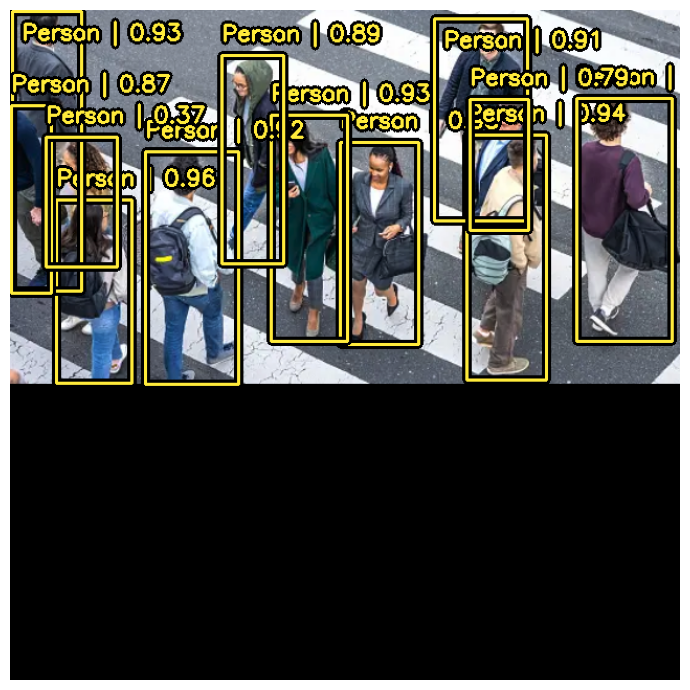

In [8]:
# Perform inference on an image
image_batch, y_pred = perform_inference('assets/people.png', pretrained_yolov8_model)

# Visualize the inference results
visualize_results(image_batch, y_pred)

In [9]:
# Load RetineNet Backbone
pretrained_retina_net_model = keras_cv.models.RetinaNet.from_preset(
        "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
    )
pretrained_retina_net_model.summary()

100%|██████████| 5.37k/5.37k [00:00<00:00, 3.74MB/s]


100%|██████████| 136M/136M [00:04<00:00, 29.9MB/s]


Model: "retina_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, None,     │ 23,561,152 │ images[0][0]      │
│ (Functional)        │ None, 512),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 1024),      │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 2048)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_pyramid     │ [(None, None,     │  7,997,440 │ functional_1[0][… │
│ (FeaturePyramid)    │ None, 256),       │            │ functional_1[0][… │
│                     │ (None, None,      │            │ functional_1[0][… │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_1   │ (None, None,      │  1,853,220 │ feature_pyramid[… │
│ (PredictionHead)    │ None, 36)         │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head     │ (None, None,      │  2,185,140 │ feature_pyramid[… │
│ (PredictionHead)    │ None, 180)        │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, None, 20)  │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, None, 20)  │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, None, 20)  │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 35,596,952 (135.79 MB)

 Trainable params: 35,543,832 (135.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step


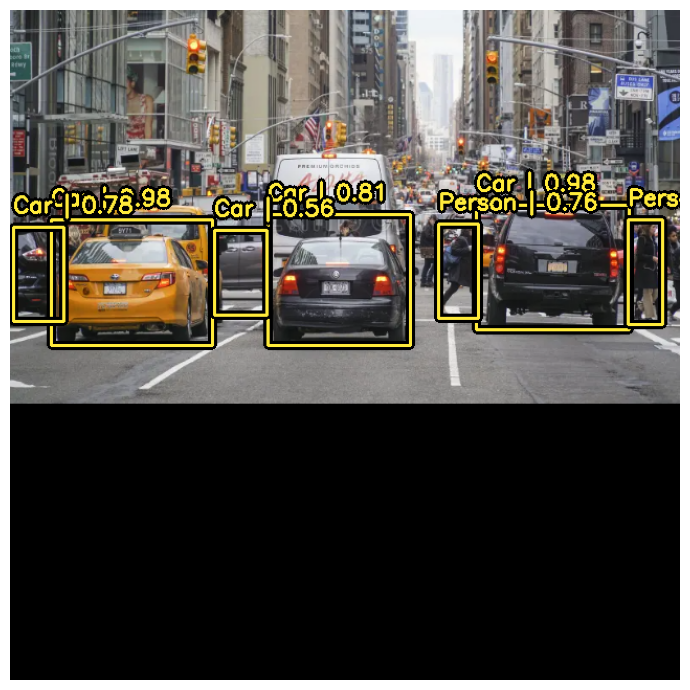

In [10]:
# Perform inference on an image
image_batch, y_pred = perform_inference('assets/traffic-scene.png', pretrained_retina_net_model)

# Visualize the inference results
visualize_results(image_batch, y_pred)

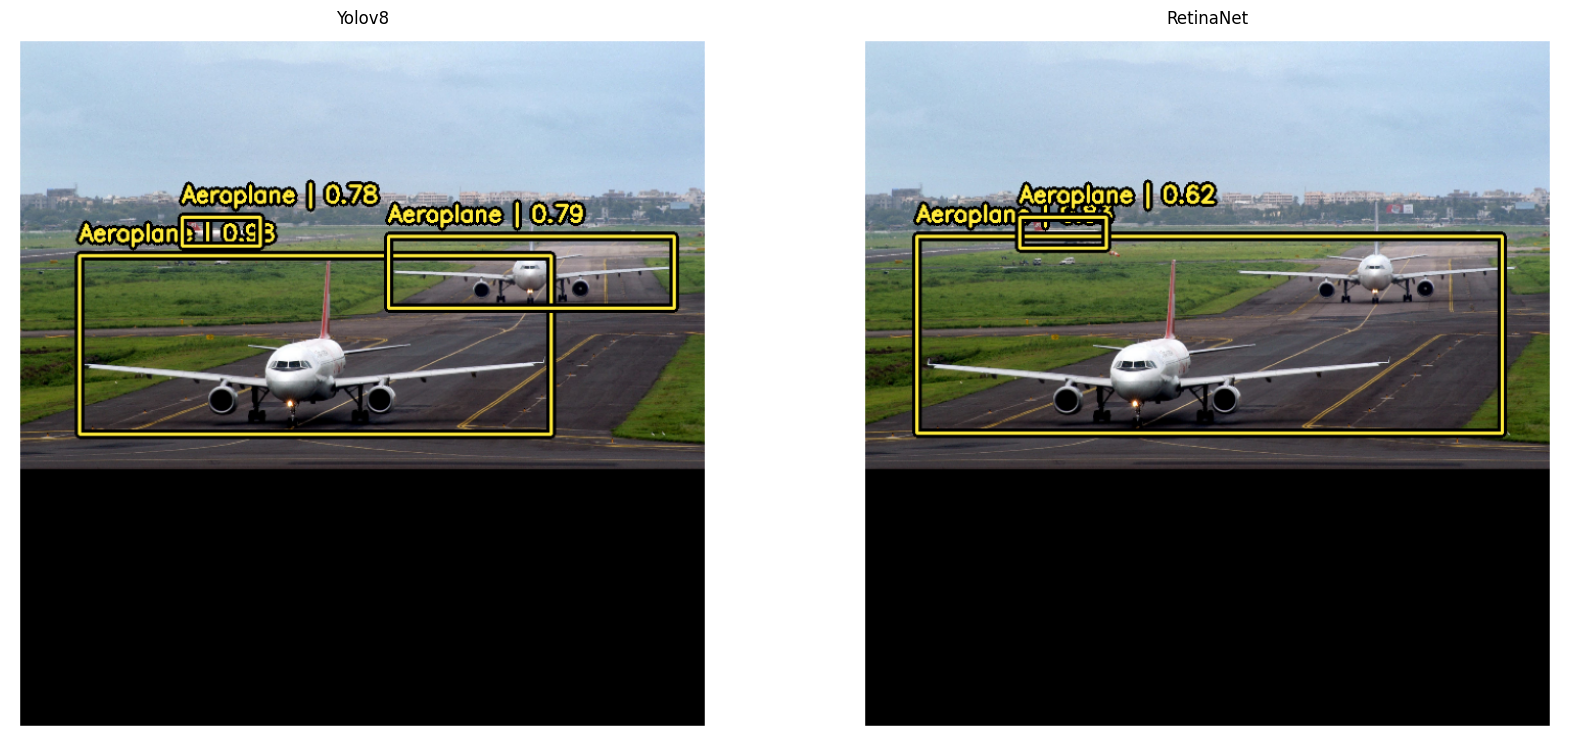

In [11]:
def compare_images(image_path1, title1, image_path2, title2):
    # Load the images
    img1 = mpimg.imread(image_path1)
    img2 = mpimg.imread(image_path2)

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figure size as needed

    # Display first image
    axes[0].imshow(img1)
    axes[0].set_title(title1)
    axes[0].axis('off')  # Hide the axis

    # Display second image
    axes[1].imshow(img2)
    axes[1].set_title(title2)
    axes[1].axis('off')  # Hide the axis

    plt.show()


compare_images(
    'assets/Predictions/Yolov8_aero_pred.png', 'Yolov8',
    'assets/Predictions/RetinaNet_aero_pred.png', 'RetinaNet')

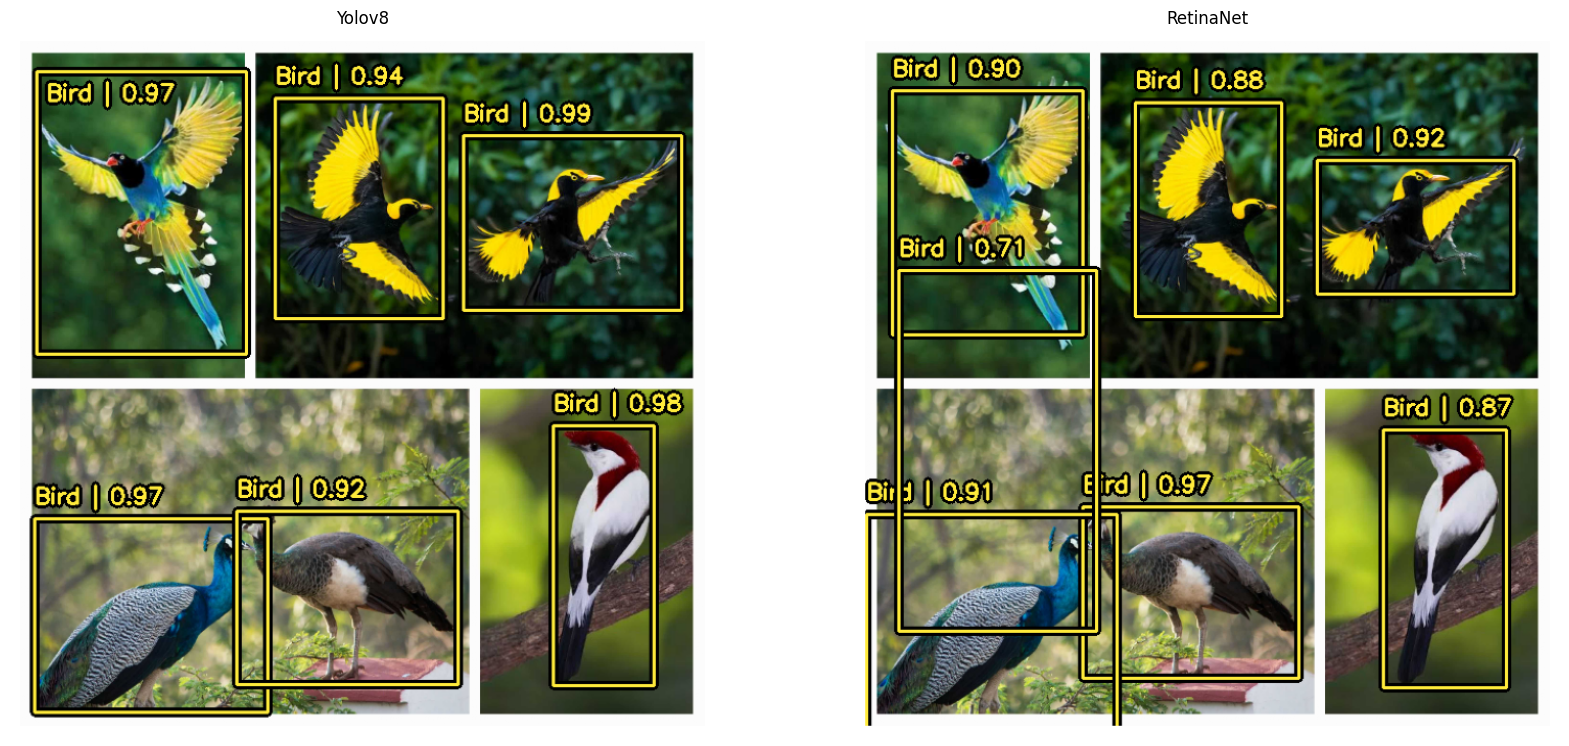

In [12]:
compare_images(
    'assets/Predictions/Yolov8_birds_pred.png', 'Yolov8',
    'assets/Predictions/RetinaNet_birds_pred.png', 'RetinaNet')

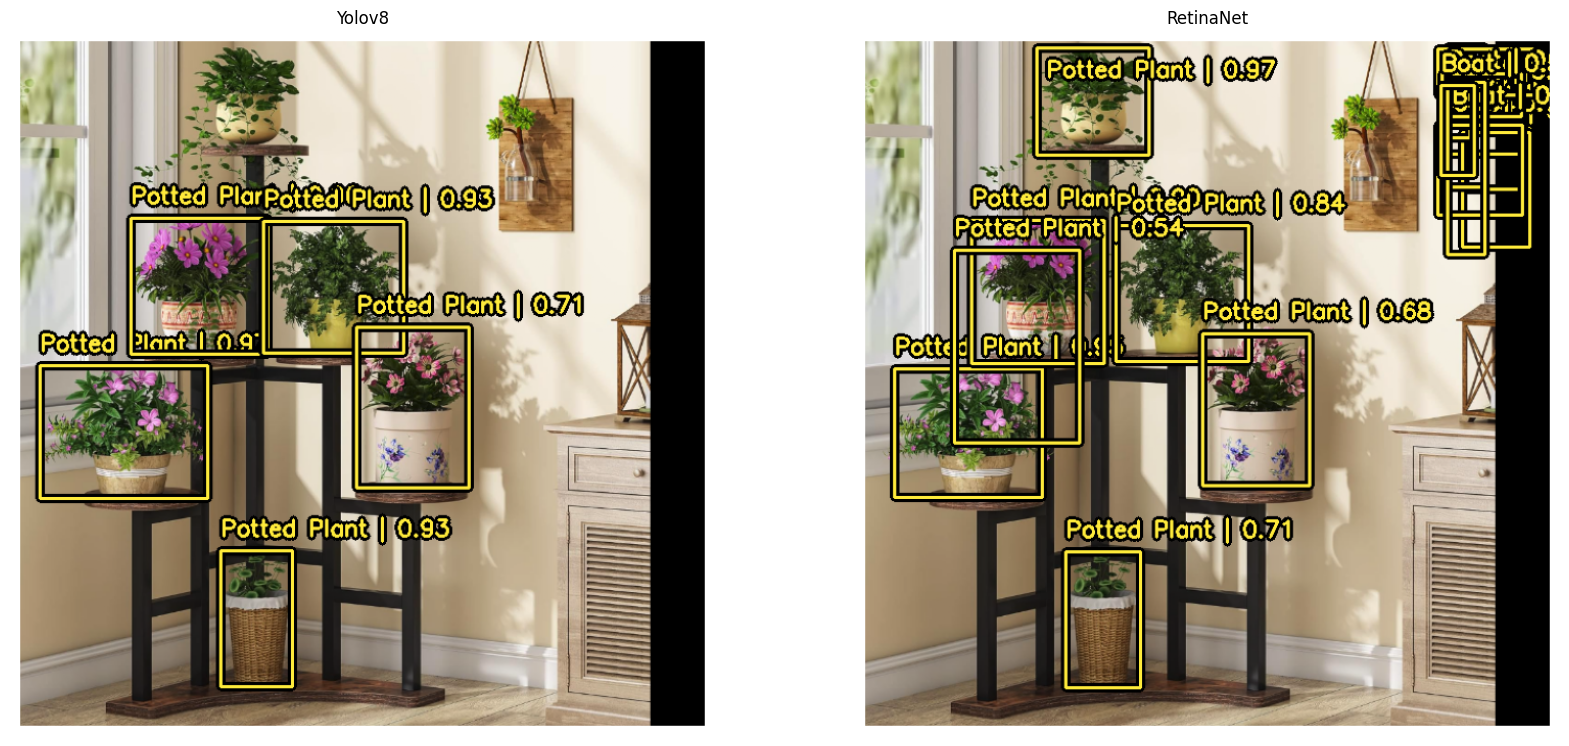

In [13]:
compare_images(
    'assets/Predictions/Yolov8_potted_pred.png', 'Yolov8',
    'assets/Predictions/Retinanet_potted_pred.png', 'RetinaNet')